# Attribute Information


    Age (numeric)
    Sex (text: male, female)
    Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
    Housing (text: own, rent, or free)
    Saving accounts (text - little, moderate, quite rich, rich)
    Checking account (numeric, in DM - Deutsch Mark)
    Credit amount (numeric, in DM)
    Duration (numeric, in month)
    Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)


# Cleaning Data and Exploration Data Analysis 

> Pada notebook ini akan dilakukannya pembersihan missing value dan eksplorasi data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as ss
from sklearn.neighbors import KernelDensity
from scipy.stats import mannwhitneyu, chi2_contingency
from scipy.stats import shapiro

import warnings 
warnings.filterwarnings('ignore')

In [2]:
credit = pd.read_csv('datasets_9109_12699_german_credit_data.csv').drop('Unnamed: 0', axis = 1)

In [3]:
credit.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [4]:
pd.DataFrame({'dataFeatures' : credit.columns, 'dataType' : credit.dtypes.values, 
              'null' : [credit[i].isna().sum() for i in credit.columns],
              'nullPct' : [((credit[i].isna().sum()/len(credit[i]))*100).round(2) for i in credit.columns],
             'Nunique' : [credit[i].nunique() for i in credit.columns],
             'uniqueSample' : [list(pd.Series(credit[i].unique()).sample(2)) for i in credit.columns]}).reset_index(drop = True)

,dataFeatures,dataType,null,nullPct,Nunique,uniqueSample
0,Age,int64,0,0.0,53,"[40, 37]"
1,Sex,object,0,0.0,2,"[male, female]"
2,Job,int64,0,0.0,4,"[0, 3]"
3,Housing,object,0,0.0,3,"[free, rent]"
4,Saving accounts,object,183,18.3,4,"[rich, nan]"
5,Checking account,object,394,39.4,3,"[rich, nan]"
6,Credit amount,int64,0,0.0,921,"[1316, 3051]"
7,Duration,int64,0,0.0,33,"[24, 7]"
8,Purpose,object,0,0.0,8,"[car, education]"
9,Risk,object,0,0.0,2,"[bad, good]"


In [5]:
#Correlation measurement untuk data kategorikal dan data numerikal
def correlation_ratio(categories, measurement):
    fcat,_ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0, cat_num):
        cat_measures = measurement[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array, y_total_avg),2)))
    debadminator = np.sum(np.power(np.subtract(measurement,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/debadminator)
    return eta

#Correlation measurement untuk data kategorikal dan kategorical
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

# Central Limit Theorem (Bootstrapping)
def clt(x):
    
    good_risk = credit[credit['Risk']=='good'][x]
    bad_risk = credit[credit['Risk']=='bad'][x]
    
    mean_good = []
    mean_bad = []
    
    for i in range(1000):
        mean_good.append(good_risk.sample(len(good_risk), replace = True).mean())
        mean_bad.append(bad_risk.sample(len(bad_risk), replace = True).mean())   
    
    #Confidence level = 0.95, significance level = 0.05
    credit_good_lower = np.percentile(mean_good, 25)
    credit_good_upper = np.percentile(mean_good, 75)
    credit_bad_lower = np.percentile(mean_bad, 25)
    credit_bad_upper = np.percentile(mean_bad, 75)
    
    fig = plt.figure(figsize = (15,5))
    ax = fig.add_axes([0,0,1,1])
    ax.set_title('Bootstrap distribution of the mean ({})'.format(x))    
        
    txt_good_lower = str(round(credit_good_lower,2))
    txt_good_upper = str(round(credit_good_upper,2))
    txt_bad_lower = str(round(credit_bad_lower,2))
    txt_bad_upper = str(round(credit_bad_upper,2))
    
    #membuat garis conf.level
    ax.axvline(credit_good_lower, linestyle = '--')
    ax.axvline(credit_good_upper, linestyle = '--')
    ax.axvline(credit_bad_lower, c = 'red',  linestyle = '--')
    ax.axvline(credit_bad_upper, c = 'red', linestyle = '--')
    
    #membuat Text    
    ax.text(credit_good_lower, .7, ha='center', va='center', rotation = 'vertical', s = txt_good_lower,
            backgroundcolor='white')
    ax.text(credit_good_upper, .7, ha='center', va='center', rotation = 'vertical', s = txt_good_upper,
            backgroundcolor='white')
    ax.text(credit_bad_lower, .7, ha='center', va='center', rotation = 'vertical', s = txt_bad_lower,
            backgroundcolor='white')
    ax.text(credit_bad_upper, .7, ha='center', va='center', rotation = 'vertical', s = txt_bad_upper,
           backgroundcolor='white')

    
    sns.distplot(mean_good, hist = False, label = 'good', ax = ax)   
    sns.distplot(mean_bad, hist = False, label = 'bad', color = 'red', ax = ax)

# Check Correlation

## Correlation Matrix Between Numerical Features

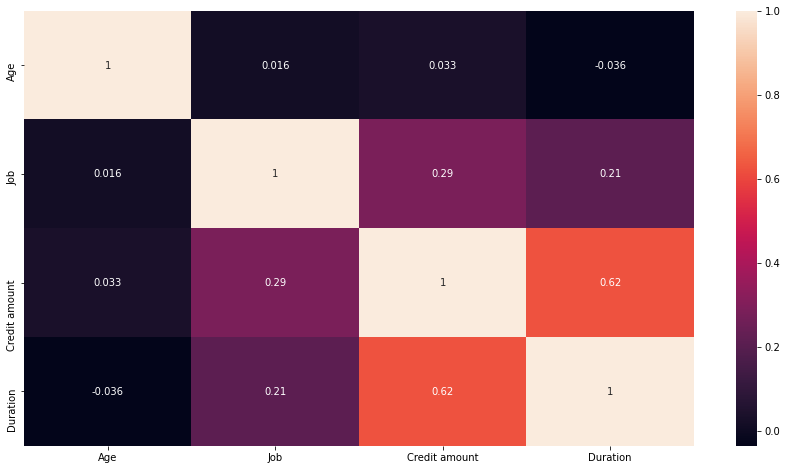

In [6]:
plt.figure(figsize = (15,8))
sns.heatmap(credit.corr(), annot = True)

## Correlation Matrix Between Categorical Features

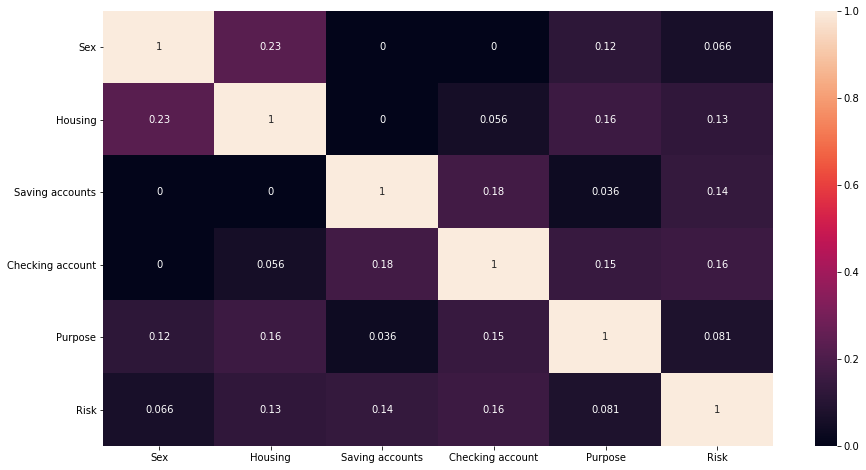

In [7]:
categorical = credit.select_dtypes('object')

corrCat = []

for i in categorical.columns:
    mat = []
    for j in categorical.columns:
        mat.append(cramers_v(credit[i],credit[j]))
    corrCat.append(mat)
    
dfcramers = pd.DataFrame(corrCat, index = categorical.columns, columns = categorical.columns)
plt.figure(figsize = (15,8))
sns.heatmap(dfcramers,annot = True)

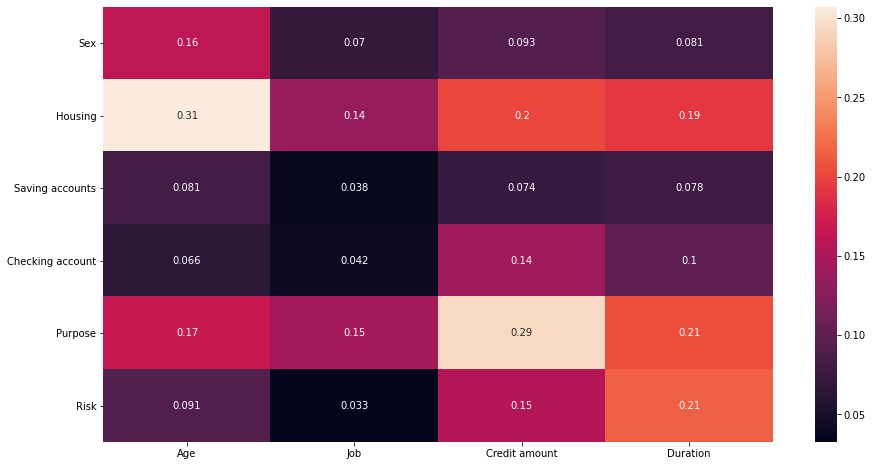

In [8]:
numerical = credit.drop(categorical, axis = 1)

corrNumCat = []

for i in categorical.columns:
    mat2 = []
    for j in numerical.columns:
        mat2.append(correlation_ratio(credit[i],credit[j]))
    corrNumCat.append(mat2)
    
dfcramers = pd.DataFrame(corrNumCat, index = categorical.columns, columns = numerical.columns)
plt.figure(figsize = (15,8))
sns.heatmap(dfcramers,annot = True)

> Dari analisa di atas, fitur-fitur tidak terlihat adanya korelasi yang kuat dengan target. Yang paling mencolok durasi dan jumlah kredit, namun ini suatu yang wajar mengingat durasi adalah fitur waktu.

# Handling Missing Values

## Saving accounts & Credit accounts

Kedua fitur ini memiliki korelasi, meski tidak sangat kuat namun tetap patut dianalisa.

In [9]:
pd.crosstab(credit['Saving accounts'],credit['Checking account'])

Checking account,little,moderate,rich
Saving accounts,,,
little,219,152,41
moderate,12,47,5
quite rich,8,11,4
rich,6,14,3


In [10]:
def imputeSaving(x): # x-->credit[['Saving accounts', 'Checking account']]
    if x['Checking account'] == 'little' and pd.isna(x['Saving accounts']):
        return 'little'
    elif x['Checking account'] == 'moderate' and pd.isna(x['Saving accounts']):
        return 'moderate'
    elif x['Checking account'] == 'rich' and pd.isna(x['Saving accounts']):
        return 'rich'
    else:
        return x['Saving accounts']

In [11]:
credit['Saving accounts'] = credit[['Saving accounts', 'Checking account']].apply(imputeSaving, axis = 1)

In [12]:
credit.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts      99
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [13]:
def imputeChecking(x): # x-->credit[['Saving accounts', 'Checking account']]
    if x['Saving accounts'] == 'little' and pd.isna(x['Checking account']):
        return 'little'
    elif x['Saving accounts'] == 'moderate' and pd.isna(x['Checking account']):
        return 'moderate'
    elif x['Saving accounts'] == 'rich' and pd.isna(x['Checking account']):
        return 'rich'
    else:
        return x['Checking account']

In [14]:
credit['Checking account'] = credit[['Saving accounts', 'Checking account']].apply(imputeChecking, axis = 1)

In [15]:
credit.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts      99
Checking account    139
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [16]:
pd.crosstab(credit['Saving accounts'],credit['Risk'], normalize = True)

Risk,bad,good
Saving accounts,,
little,0.256382,0.445061
moderate,0.045505,0.118757
quite rich,0.012209,0.057714
rich,0.008879,0.055494


In [17]:
pd.crosstab(credit['Checking account'],credit['Risk'], normalize = True)

Risk,bad,good
Checking account,,
little,0.186992,0.353078
moderate,0.126597,0.231127
rich,0.018583,0.083624


Menarik, melihat justru resikonya kecil saat orang-orang menyimpan sedikit

In [18]:
credit['Checking account'].fillna('little', inplace = True)
credit['Saving accounts'].fillna('little', inplace = True)

> Saya mengisi semua missing value dengan 'little' karena melihat nilai 'little' cukup dominan pada dataset ini.

In [19]:
credit.isna().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

In [20]:
# credit.to_csv('credit_clean.csv')

# Exploration Data Analysis

## Hypothesis Testing

### Normality Test

In [21]:
shap = []

for i in numerical.columns:
    if shapiro(credit[i])[1] < 0.05:
        shap.append('Reject Null Hypothesis')
    else:
        shap.append('Fail To reject Null Hypothesis')
        
pd.DataFrame({'Hypothesis' : shap}, index = numerical.columns)

,Hypothesis
Age,Reject Null Hypothesis
Job,Reject Null Hypothesis
Credit amount,Reject Null Hypothesis
Duration,Reject Null Hypothesis


### Significance Test

In [22]:
chi2 = []

for i in categorical.columns:
    if chi2_contingency(pd.crosstab(credit['Risk'], credit[i]))[1] < 0.05:
        chi2.append('Reject Null Hypothesis')
    else:
        chi2.append('Fail To Reject Null Hypothesis')
        
pd.DataFrame({'Hypothesis' : chi2}, index = categorical.columns)

,Hypothesis
Sex,Reject Null Hypothesis
Housing,Reject Null Hypothesis
Saving accounts,Reject Null Hypothesis
Checking account,Reject Null Hypothesis
Purpose,Fail To Reject Null Hypothesis
Risk,Reject Null Hypothesis


In [23]:
mannwhit = []

for i in numerical.columns:
    if mannwhitneyu(credit[credit['Risk'] == 'bad'][i],credit[credit['Risk'] == 'good'][i])[1] < 0.05:
        mannwhit.append('Reject Null Hypothesis')
    else:
        mannwhit.append('Fail To reject Null Hypothesis')

pd.DataFrame({'Hypothesis' : mannwhit}, index = numerical.columns)

,Hypothesis
Age,Reject Null Hypothesis
Job,Fail To reject Null Hypothesis
Credit amount,Reject Null Hypothesis
Duration,Reject Null Hypothesis


> Ternyata secara statistik, jumlah pekerjaan dan alasan peminjaman tidaklah fitur yang berpengaruh dalam peminjaman yang baik atau tidak. 

## Age

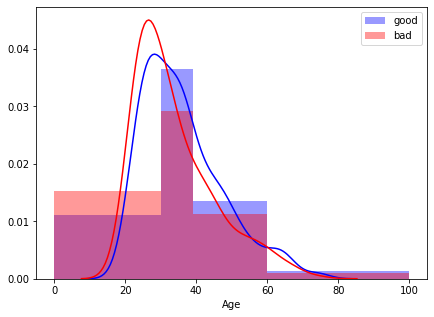

In [24]:
plt.figure(figsize = (7,5))

sns.distplot(credit[credit['Risk'] == 'good']['Age'], label = 'good', color = 'blue', bins = [0, 30, 39, 60, 100])
sns.distplot(credit[credit['Risk'] == 'bad']['Age'], label = 'bad', color = 'red', bins = [0, 30, 39, 60, 100])

plt.legend()

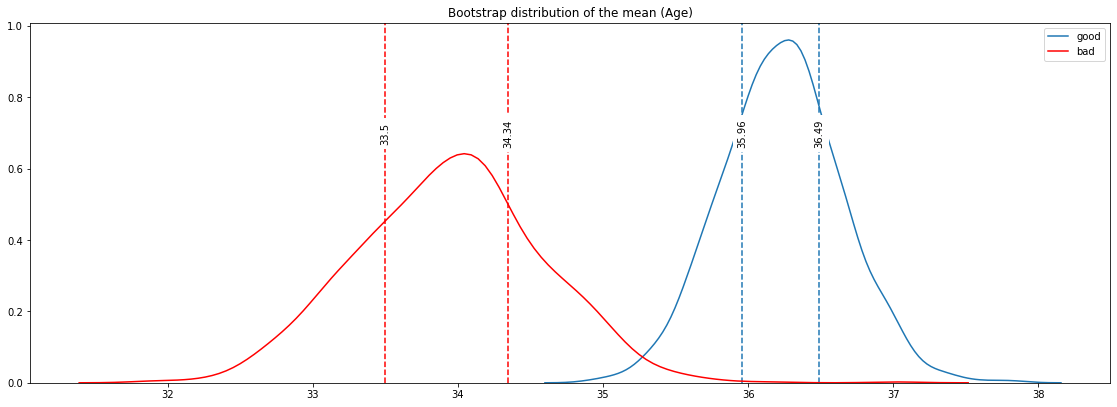

In [25]:
clt('Age')

In [26]:
def biningAge(x):
    if x < 30:
        return '<30'
    elif x>=30 and x< 40:
        return '30-39'
    elif x>40 and x< 60:
        return '40-59'
    else:
        return '60+'

In [27]:
credit['Age Groups'] = credit['Age'].apply(biningAge)

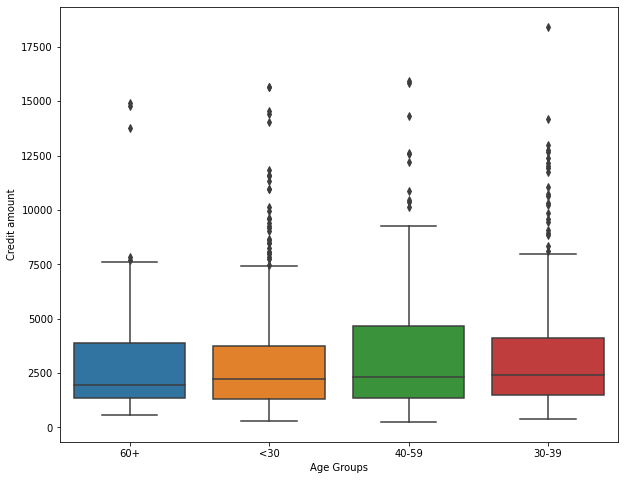

In [28]:
plt.figure(figsize = (10,8))
sns.boxplot(credit['Age Groups'], credit['Credit amount'])

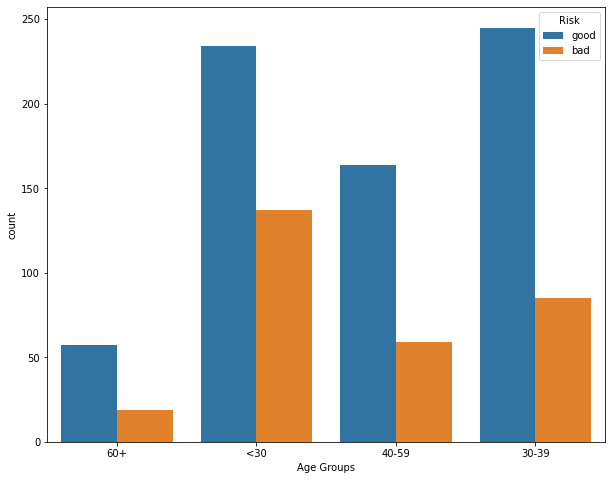

In [29]:
plt.figure(figsize = (10,8))
sns.countplot(credit['Age Groups'], hue = credit['Risk'])

In [40]:
pd.crosstab(credit['Age Groups'], credit['Saving accounts'], normalize = 'index')

Saving accounts,little,moderate,quite rich,rich
Age Groups,,,,
30-39,0.700000,0.172727,0.063636,0.063636
40-59,0.744395,0.116592,0.071749,0.067265
60+,0.763158,0.092105,0.092105,0.052632
<30,0.743935,0.156334,0.051213,0.048518


In [42]:
credit.groupby('Age Groups').mean()['Credit amount']

Age Groups
30-39    3404.260606
40-59    3398.156951
60+      3211.157895
<30      3088.989218
Name: Credit amount, dtype: float64

Dari visualisasi di atas dapat disimpulkan bahwa:
* Memberi pinjaman ke anak-anak muda lebih beresiko daripada orang-orang yang berumur di atas 30 tahun. 
* Secara populasi, rata-rata orang-orang yang berumur muda juga lebih beresiko daripada orang-orang yang berumur cukup tua.
* Dan ini jelas, kebanyakan orang-orang yang meminjam mereka punya kebiasaan menyimpan yang sedikit

## Sex

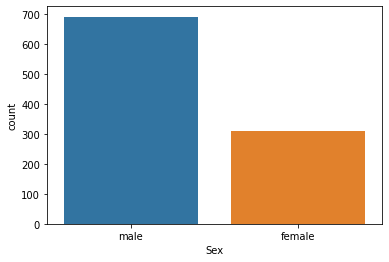

In [30]:
sns.countplot(credit['Sex'])

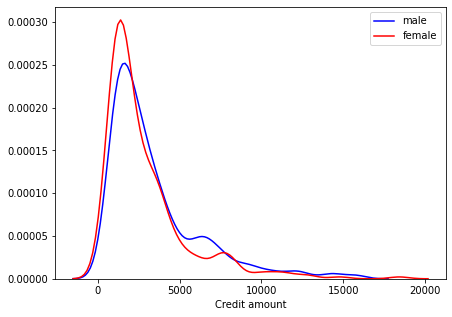

In [31]:
plt.figure(figsize = (7,5))

sns.distplot(credit[credit['Sex'] == 'male']['Credit amount'], label = 'male', color = 'blue', hist = False)
sns.distplot(credit[credit['Sex'] == 'female']['Credit amount'], label = 'female', color = 'red', hist = False)

plt.legend()

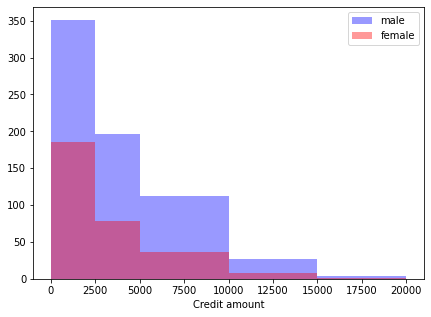

In [32]:
plt.figure(figsize = (7,5))

sns.distplot(credit[credit['Sex'] == 'male']['Credit amount'], label = 'male', color = 'blue', bins = [0, 2500, 5000, 10000, 15000, 20000], kde = False)
sns.distplot(credit[credit['Sex'] == 'female']['Credit amount'], label = 'female', color = 'red', bins = [0, 2500, 5000, 10000, 15000, 20000], kde = False)

plt.legend()

> Kesimpulan dari analisa di atas, bahwa laki-laki lebih sering melakukan peminjaman dan secara peluang jumlah kredit laki-laki lebih kecil daripada jumlah kredit perempuan.

## Duration

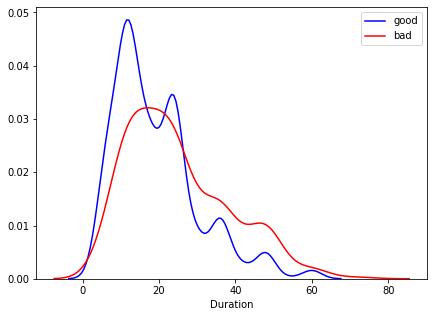

In [46]:
plt.figure(figsize = (7,5))

sns.distplot(credit[credit['Risk'] == 'good']['Duration'], label = 'good', color = 'blue', hist = False)
sns.distplot(credit[credit['Risk'] == 'bad']['Duration'], label = 'bad', color = 'red', hist = False)

plt.legend()

> Dari plot di atas terlihat disekitaran 30 bulan ke atas, dia menjadi kredit yang beresiko.

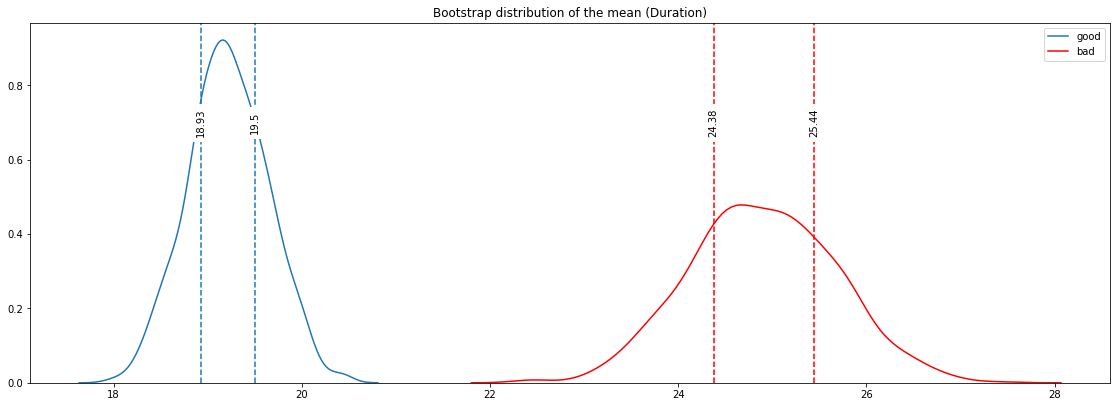

In [45]:
clt('Duration')

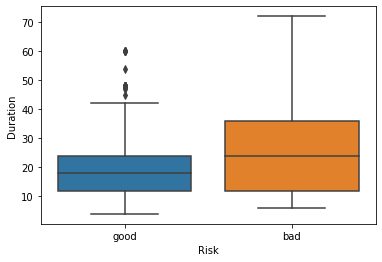

In [47]:
sns.boxplot(credit['Risk'], credit['Duration'])

> Dengan analisa di atas, sudah cukup menyimpulkan bahwa semakin lama durasinya juga semakin beresiko. Rekomendasi saya, jangan lebih dari 22 bulan. 

## Credit Amount

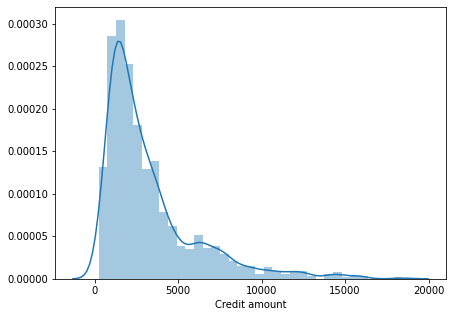

In [33]:
plt.figure(figsize = (7,5))

sns.distplot(credit['Credit amount'])

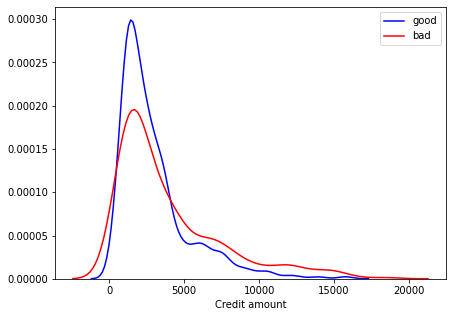

In [34]:
plt.figure(figsize = (7,5))

sns.distplot(credit[credit['Risk'] == 'good']['Credit amount'], label = 'good', color = 'blue', hist = False)
sns.distplot(credit[credit['Risk'] == 'bad']['Credit amount'], label = 'bad', color = 'red', hist = False)

plt.legend()

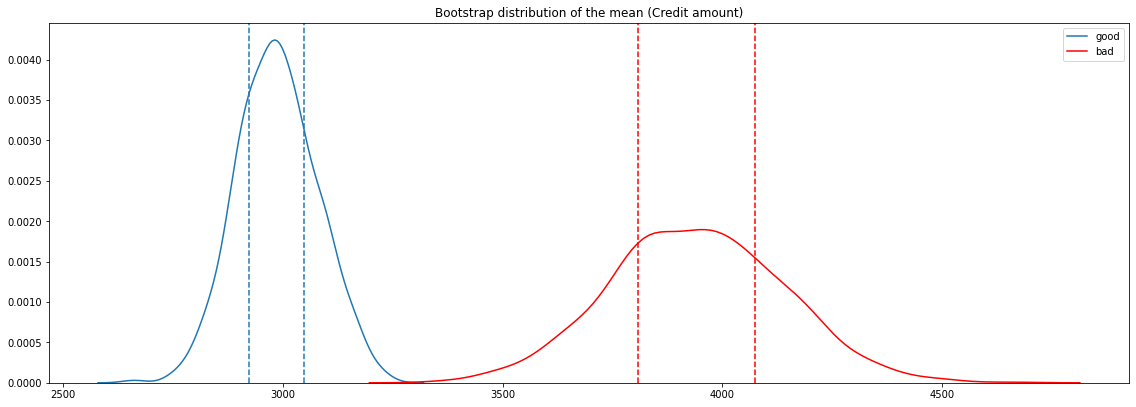

In [35]:
good_risk = credit[credit['Risk']=='good']['Credit amount']
bad_risk = credit[credit['Risk']=='bad']['Credit amount']
    
mean_good = []
mean_bad = []
    
for i in range(1000):
    mean_good.append(good_risk.sample(len(good_risk), replace = True).mean())
    mean_bad.append(bad_risk.sample(len(bad_risk), replace = True).mean())   
     
#Confidence level = 0.95, significance level = 0.05
credit_good_lower = np.percentile(mean_good, 25)
credit_good_upper = np.percentile(mean_good, 75)
credit_bad_lower = np.percentile(mean_bad, 25)
credit_bad_upper = np.percentile(mean_bad, 75)

fig = plt.figure(figsize = (15,5))
ax = fig.add_axes([0,0,1,1])
ax.set_title('Bootstrap distribution of the mean ({})'.format('Credit amount')) 

ax.axvline(credit_good_lower, linestyle = '--')
ax.axvline(credit_good_upper, linestyle = '--')
ax.axvline(credit_bad_lower, c = 'red',  linestyle = '--')
ax.axvline(credit_bad_upper, c = 'red', linestyle = '--')

sns.distplot(mean_good, hist = False, label = 'good', ax = ax)   
sns.distplot(mean_bad, hist = False, label = 'bad', color = 'red', ax = ax)

> Kesimpulan dari analisa-analisa di atas: Semakin besar jumlah kreditnya, semakin beresiko juga pinjamannya. Ini juga cukup beralasan, karena memang semakin besar jumlah kreditnya, juga pastinya akan semakin sulit untuk mengembalikannya. 

# Conclusion

Akan jauh lebih beresiko saat anak-anak muda jika yang melakukan peminjaman dan juga, tidak menjadi relevan jika kita melihat kebiasaan mereka dalam menyimpan uang. Harus ada pengukuran yang tepat, untuk menentukan mana orang yang tidak beresiko dipinjamkan dan mana yang tidak. Jumlah pekerjaan juga tidak menjadi relevan. 